# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [332]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import matplotlib.pyplot as plt

ITER = 0


In [333]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01
        # self.input = None
        # self.output = None

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros((output_size, 1))
        self.input = None
        self.output = None
        self.iter = 0

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.dot(self.weights, x) + self.biases
        self.iter += 1
        return self.output

    # def backward(self, output_error_derivative)->np.ndarray:
    #     input_error_derivative = np.dot(self.weights.T, output_error_derivative)
    #     weights_error_derivative = np.dot(output_error_derivative, self.input.T)
    #     self.weights -= self.learning_rate * weights_error_derivative
    #     self.biases -= self.learning_rate * output_error_derivative
    #     # input_error_derivative = np.dot(self.weights.T, output_error_derivative)
    #     # self.weights_grad = np.dot(output_error_derivative, self.input.T)
    #     # self.biases_grad = np.sum(output_error_derivative, axis=1, keepdims=True)
    #     return input_error_derivative

    def backward(self, output_error_derivative) -> np.ndarray:
        input_error_derivative = np.dot(self.weights.T, output_error_derivative)
        weights_error_derivative = np.dot(output_error_derivative, self.input.T)
        self.weights -= self.learning_rate * weights_error_derivative
        self.biases -= self.learning_rate * np.sum(output_error_derivative, axis=1, keepdims=True)
        return input_error_derivative



class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative)->np.ndarray:
        return output_error_derivative * (1 - np.tanh(self.input) ** 2)
    
class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, output_error_derivative) -> np.ndarray:
        return output_error_derivative * self.output * (1 - self.output)
    
class ReLU(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = np.maximum(0, x)
        return self.output

    def backward(self, output_error_derivative) -> np.ndarray:
        return output_error_derivative * (self.input > 0).astype(int)


class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(x, y)

    def loss_derivative(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            learning_rate:float,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        all_current_loss = []
        epoch_loss = np.zeros(1437)
        for epoch in range(epochs):
            for i in range(len(x_train)):
                # Forward propagation
                # print(x_train[i].shape)
                # x_train[i] = x_train[i].reshape((-1, 1))
                output = self(x_train[i])
                # if i==0:
                    # print(output)
                # Calculate loss and its derivative
                correct_result = np.zeros((10, 1)) - 1
                temp = y_train[i]
                correct_result[y_train[i]] = 1
                if epoch == 99:
                    pass
                current_loss = self.loss.loss(output, correct_result)
                loss_derivative = self.loss.loss_derivative(output, correct_result)
                epoch_loss[i] = current_loss
                # Backpropagation
                for layer in reversed(self.layers):
                    loss_derivative = layer.backward(loss_derivative)

                # Update weights and biases
                # for layer in self.layers:
                #     if isinstance(layer, FullyConnected):
                #         layer.weights -= layer.learning_rate * layer.weights_grad
                #         layer.biases -= layer.learning_rate * layer.biases_grad
            all_current_loss.append(np.mean(epoch_loss))
        fig2 = plt.plot(all_current_loss)
        # plt.ylim([-10, 20])
        # plt.xlabel('Epizod')
        # plt.ylabel('Suma nagród')
        # plt.title(f'Wykres sumy nagród uzyskanych przy rozwiązywaniu problemu\nLiczba podejść = {testing_iter}')
        plt.show()

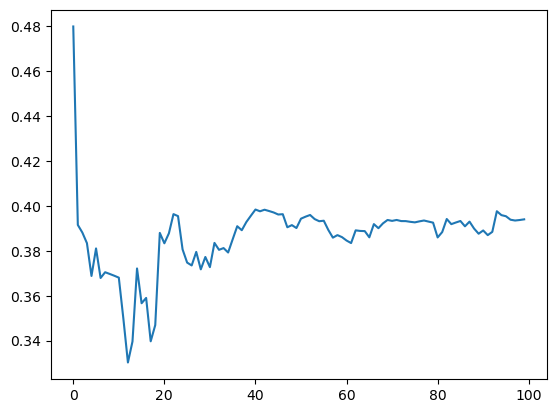

360
Accuracy on test set: 0.09722222222222222


In [334]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Załadowanie zbioru danych cyfr MNIST
digits = load_digits()

# Przygotowanie danych
X = digits.data
y = digits.target

# Standaryzacja danych
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Konwersja etykiet na kodowanie one-hot
# def one_hot_encode(labels, num_classes):
#     encoded = np.zeros((len(labels), num_classes))
#     for i in range(len(labels)):
#         encoded[i, labels[i]] = 1
#     return encoded

num_classes = 10  # Dla MNIST cyfr mamy 10 klas (cyfry od 0 do 9)
# y_train_encoded = one_hot_encode(y_train, num_classes)
# y_test_encoded = one_hot_encode(y_test, num_classes)


# Inicjalizacja sieci
layers = [
    FullyConnected(input_size=X_train.shape[1], output_size=128),  # Warstwa wejściowa
    Tanh(),  # Funkcja aktywacji
    FullyConnected(input_size=128, output_size=64),  # Ukryta warstwa
    Tanh(),  # Funkcja aktywacji
    FullyConnected(input_size=64, output_size=num_classes),  # Warstwa wyjściowa
    Tanh()
]

# layers = [
#     FullyConnected(input_size=X_train.shape[1], output_size=128),  # Warstwa wejściowa
#     ReLU(),  # Funkcja aktywacji
#     FullyConnected(input_size=128, output_size=64),  # Ukryta warstwa
#     ReLU(),  # Funkcja aktywacji
#     FullyConnected(input_size=64, output_size=num_classes),  # Warstwa wyjściowa
#     ReLU()
# ]

learning_rate = 0.01
network = Network(layers=layers, learning_rate=learning_rate)

# Kompilacja sieci z funkcją straty
loss = Loss(loss_function=lambda x, y: np.mean((x - y) ** 2),
            loss_function_derivative=lambda x, y: 2 * (x - y))
network.compile(loss=loss)

# Uczenie sieci
epochs = 100
# print(X_train[1].shape)
# print(type(X_train))
# temp = X_train[1].reshape((64, 1))
# print(X_train.shape)
new_X_train = np.empty((1437, 64, 1))
# print(temp.shape)
for i in range(len(X_train)):
    temp = X_train[i]
    temp = temp.reshape((64, 1))
    new_X_train[i] = temp
    pass
# print(X_train.shape)
# print(X_train[1].shape)
# print(new_X_train.shape)
# print(new_X_train[1].shape)
network.fit(new_X_train, y_train, epochs, learning_rate)

# Ocena na danych testowych
predictions = []
new_X_test = np.empty((1437, 64, 1))
# print(temp.shape)
for i in range(len(X_test)):
    temp = X_test[i]
    temp = temp.reshape((64, 1))
    new_X_test[i] = temp
# print(new_X_test[1])
# print(X_test[1])
for i in range(len(X_test)):
    output = network(new_X_test[i])
    prediction = np.argmax(output)
    predictions.append(prediction)
print(len(predictions))
accuracy = np.mean(np.array(predictions) == y_test)
print(f"Accuracy on test set: {accuracy}")



# Eksperymenty

# Wnioski